In [1]:
import os
import sys
import argparse
from codebase import args as codebase_args
from pprint import pprint
import tensorflow as tf
from codebase.utils import get_data
from codebase.utils import exact_accuracy
import numpy as np
from glob import glob
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib as plt
from more_itertools import chunked

In [2]:
def build_model(src, trg, design, trim):
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument('--src',    type=str,   default='stl', help="Src data")
    parser.add_argument('--trg',    type=str,   default='cifar',    help="Trg data")
    parser.add_argument('--design', type=str,   default='v17_y_nin',     help="design")
    parser.add_argument('--trim',   type=int,   default=5,         help="Trim")
    parser.add_argument('--pert',   type=str,   default='vat',     help="Type of perturbation")
    parser.add_argument('--ball',   type=float, default=3.5,       help="Ball weight")
    parser.add_argument('--cw',     type=float, default=0,      help="Conditional entropy weight")
    parser.add_argument('--dw',     type=float, default=0,      help="Domain weight")
    parser.add_argument('--gw',     type=float, default=0.0,       help="Gen weight")
    parser.add_argument('--y-emp',  type=int,   default=0,         help="Whether to use empirical y")
    parser.add_argument('--te',     type=float, default=0,         help="Trg embedding ball weight")
    parser.add_argument('--se',     type=float, default=0,         help="Src embedding ball weight")
    parser.add_argument('--tbw',    type=float, default=0,      help="Trg ball weight")
    parser.add_argument('--gbw',    type=float, default=0.0,       help="Fake ball weight")
    parser.add_argument('--sbw',    type=float, default=0,         help="Src ball weight")
    parser.add_argument('--lr',     type=float, default=1e-3,      help="Learning rate")
    parser.add_argument('--dirt',   type=int,   default=50000,         help="Flag for DIRT algorithm")
    parser.add_argument('--init',   type=int,   default=0,         help="Flag for re-init")
    parser.add_argument('--pivot',  type=int,   default=90000,     help="Pivot iteration for up/dn/dwdn")
    parser.add_argument('--uval',   type=float, default=0,         help="Up value")
    parser.add_argument('--dcval',  type=float, default=0,         help="Down value. Does not apply to SBW!")
    parser.add_argument('--up',     type=int,   default=0,         help="Ramping up flag")
    parser.add_argument('--dn',     type=int,   default=0,         help="Ramping down flag")
    parser.add_argument('--dwdn',   type=int,   default=0,         help="Ramping down dw flag")
    parser.add_argument('--phase',  type=int,   default=0,         help="Init phase v. DIRT phase")
    parser.add_argument('--run',    type=int,   default=999,       help="Run index")
    codebase_args.args = args = parser.parse_args([])

    args.src = src
    args.trg = trg
    args.design = design 
    args.trim = trim
    
    from codebase.models.dann_embed import dann_embed

    tf.reset_default_graph()
    M = dann_embed()
    M.sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
#    trg = get_data(args.trg)
    
    return M, saver, trg

def get_confusion_matrix(M, saver, data, restoration_names, iteration=80000):
    x_chunked = list(chunked(data.images,500))
    y_chunked = list(chunked(data.labels,500))
    print(restoration_names)
    path = os.path.join('checkpoints', restoration_names[0], 'model-{:05d}'.format(iteration))

    
    for i in range(len(x_chunked)):
        x_data, y_data = x_chunked[i], y_chunked[i]
        if i == 0:
            y_true = np.argmax(y_data,1)
        else:
            y_true = np.append(y_true, np.argmax(y_data,1))
        try:
            saver.restore(M.sess, path)
            if i == 0:
                y_pred =  M.sess.run(tf.argmax(M.ema_e,1), {M.test_x: x_data})
            else:
                y_pred = np.append(y_pred, M.sess.run(tf.argmax(M.ema_e,1), {M.test_x: x_data}))
        
        except tf.errors.NotFoundError:
            print "NOT FOUND"

    confusion = confusion_matrix(y_true, y_pred)
#    confusion = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
            
    return confusion, y_pred

def get_accuracy(M, saver, data, restoration_names, iteration=80000):
    train_test_list = []
    for rn in restoration_names:
        path = os.path.join('checkpoints', rn, 'model-{:05d}'.format(iteration))

        try:
            saver.restore(M.sess, path)
            test_acc, _ = exact_accuracy(M.fn_ema_acc, 'whatev', data.test, full=True)
            train_acc, _ = exact_accuracy(M.fn_ema_acc, 'whatev', data.train, full=False)    
            train_test_list += [[train_acc, test_acc]]
            print train_test_list[-1]

        except tf.errors.NotFoundError:
            print "NOT FOUND"
            
    return np.array(train_test_list)

# Evaluation

In [3]:
src = get_data('wifistanford')
trg = get_data('wifimexico')

Loading WifiStanford
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/fall_180220_01/05400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/fall_180220_01/05600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/fall_180220_01/05800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/fall_180220_01/06000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/fall_180220_01/06200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/fall_180220_01/06400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/fall_180220_01/06600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_

../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180220_01/06200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180220_01/06400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180220_01/06600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180220_01/06800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180220_01/07000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180220_01/07200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180220_01/07400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_th

../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180220_02/09600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180220_02/09800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180220_02/10000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180220_02/10200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180220_02/10400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180220_02/10600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180220_02/10800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_th

../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180220_03/11000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180220_03/11200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180220_03/11400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180220_03/11600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180220_03/11800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180220_03/12000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180220_03/12200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_th

../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180220_03/06000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180220_03/06200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180220_03/06400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180220_03/06600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180220_03/06800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180220_03/07000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180220_03/07200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_

../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180220_01/10000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180220_01/10200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180220_01/10400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180220_01/10600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180220_01/10800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180220_01/11000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180220_01/11200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=

../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180220_02/12800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180220_02/13000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180220_02/13200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180220_02/13400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180220_02/13600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180220_02/13800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180220_02/14000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_104_NLOS_window_size=

../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180208_01/06600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180208_01/06800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180208_01/07000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180208_01/07200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180208_01/07400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180208_01/07600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180208_01/07800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_th

../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/fall_180208_03/07400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/fall_180208_03/07600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/fall_180208_03/07800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/fall_180208_03/08000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/fall_180208_03/08200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180208_01/05800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180208_01/06000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_s

../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180208_01/11400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180208_01/11600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180208_01/11800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180208_01/12000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180208_01/12200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180208_01/12400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180208_01/12600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_th

../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180208_02/13600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180208_02/13800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180208_02/14000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180208_02/14200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180208_02/14400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180208_02/14600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180208_03/05400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_th

../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180208_01/07000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180208_01/07200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180208_01/07400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180208_01/07600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180208_01/07800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180208_01/08000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180208_01/08200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_

../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180208_03/06400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180208_03/06600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180208_03/06800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180208_03/07000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180208_01/05000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180208_01/05200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180208_01/05400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_

../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180208_02/06600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180208_02/06800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180208_02/07000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180208_02/07200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180208_02/07400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180208_02/07600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180208_02/07800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=

../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180208_03/09000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180208_03/09200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180208_03/09400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180208_03/09600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180208_03/09800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180208_03/10000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180208_03/10200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_200_NLOS_window_size=

../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180212_02/07800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180212_02/08000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180212_02/08200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180212_02/08400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180212_02/08600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180212_03/05400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180212_03/05600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=

../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180212_01/06400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180212_01/06600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180212_01/06800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180212_01/07000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180212_01/07200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180212_01/07400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180212_02/05600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window

../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180212_01/11400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180212_01/11600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180212_01/11800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180212_01/12000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180212_01/12200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180212_01/12400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180212_01/12600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=

../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180212_02/14000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180212_02/14200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180212_02/14400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180212_02/14600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180212_03/05400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180212_03/05600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180212_03/05800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=

../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180212_01/07800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180212_02/05400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180212_02/05600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180212_02/05800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180212_02/06000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180212_02/06200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180212_02/06400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS

../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180212_03/07600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180212_03/07800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180212_01/05600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180212_01/05800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180212_01/06000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180212_01/06200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180212_01/06400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=20

../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180212_02/08600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180212_02/08800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180212_02/09000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180212_02/09200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180212_02/09400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180212_02/09600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180212_02/09800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_thr

../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180212_03/12800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180212_03/13000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180212_03/13200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180212_03/13400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180212_03/13600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180212_03/13800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180212_03/14000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_201_LOS_window_size=2000_thr

../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/fall_180214_02/06600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/fall_180214_02/06800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/fall_180214_02/07000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/fall_180214_02/07200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/fall_180214_02/07400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/fall_180214_03/05600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/fall_180214_03/05800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=

../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180214_01/07000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180214_01/07200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180214_01/07400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180214_01/07600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180214_01/07800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180214_01/08000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180214_01/08200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_th

../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180214_02/08600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180214_02/08800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180214_02/09000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180214_02/09200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180214_02/09400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180214_02/09600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180214_02/09800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_th

../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180214_03/12600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180214_03/12800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180214_03/13000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180214_03/13200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180214_03/13400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180214_03/13600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180214_03/13800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_th

../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180214_02/05000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180214_02/05200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180214_02/05400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180214_02/05600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180214_02/05800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180214_02/06000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180214_02/06200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_

../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180214_01/12600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180214_01/12800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180214_01/13000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180214_01/13200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180214_01/13400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180214_02/05600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180214_02/05800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=

../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180214_02/17000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180214_02/17200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180214_02/17400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180214_02/17600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180214_02/17800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180214_03/06800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180214_03/07000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_LOS_window_size=

../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180225_02/04600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180225_02/04800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180225_02/05000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180225_02/05200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180225_02/05400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180225_02/05600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180225_02/05800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size

../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180225_02/08800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180225_02/09000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180225_02/09200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180225_02/09400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180225_02/09600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180225_02/09800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180225_02/10000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_

../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180225_01/14000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180225_01/14200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180225_01/14400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180225_01/14600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180225_01/14800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180225_01/15000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180225_01/15200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size

../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180225_03/10800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180225_03/11000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180225_03/11200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180225_03/11400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180225_03/11600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180225_03/11800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180225_03/12000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size

../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180225_03/07400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180225_03/07600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180225_03/07800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180225_03/08000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180225_03/08200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180225_03/08400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180225_03/08600.pkl
../Pickle/norm/non_smooth/source/train/St

../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180225_01/14800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180225_01/15000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180225_01/15200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180225_01/15400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180225_01/15600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180225_01/15800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180225_01/16000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_wind

../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180225_03/10400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180225_03/10600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180225_03/10800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180225_03/11000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180225_03/11200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180225_03/11400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180225_03/11600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_219A_NLOS_wind

../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180216_02/08400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180216_03/04800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180216_03/05000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180216_03/05200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180216_03/05400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180216_03/05600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180216_03/05800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=

../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180216_01/06400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180216_01/06600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180216_01/06800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180216_01/07000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180216_01/07200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180216_02/05200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180216_02/05400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window

../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180216_01/12200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180216_01/12400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180216_01/12600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180216_01/12800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180216_01/13000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180216_01/13200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180216_01/13400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=

../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180216_02/14400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180216_02/14600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180216_02/14800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180216_03/05000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180216_03/05200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180216_03/05400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180216_03/05600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=

../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180216_01/06800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180216_01/07000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180216_01/07200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180216_01/07400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180216_01/07600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180216_01/07800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180216_01/08000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS

../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180216_02/06600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180216_02/06800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180216_02/07000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180216_02/07200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180216_02/07400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180216_03/05000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180216_03/05200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS

../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180216_01/14600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180216_01/14800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180216_02/05800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180216_02/06000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180216_02/06200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180216_02/06400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180216_02/06600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_thr

../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180216_03/08400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180216_03/08600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180216_03/08800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180216_03/09000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180216_03/09200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180216_03/09400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180216_03/09600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_LOS_window_size=2000_thr

../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180124_02/08800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180124_03/05800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180124_03/06000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180124_03/06200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180124_03/06400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180124_03/06600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180124_03/06800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_th

../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180124_01/05400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180124_01/05600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180124_01/05800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180124_01/06000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180124_01/06200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180124_01/06400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180124_01/06600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLO

../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180124_01/10400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180124_01/10600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180124_01/10800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180124_01/11000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180124_01/11200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180124_01/11400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180124_01/11600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_th

../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180124_02/13000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180124_02/13200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180124_02/13400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180124_02/13600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180124_02/13800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180124_02/14000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180124_02/14200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_th

../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180124_01/06000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180124_01/06200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180124_01/06400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180124_01/06600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180124_01/06800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180124_01/07000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180124_01/07200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_

../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180124_02/06800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180124_02/07000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180124_03/05400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180124_03/05600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180124_03/05800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180124_03/06000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180124_03/06200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_

../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180124_02/06400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180124_02/06600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180124_02/06800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180124_02/07000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180124_02/07200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180124_02/07400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180124_02/07600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=

../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180124_03/08200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180124_03/08400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180124_03/08600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180124_03/08800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180124_03/09000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180124_03/09200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180124_03/09400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_229_NLOS_window_size=

../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180221_02/07200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180221_02/07400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180221_02/07600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180221_02/07800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180221_02/08000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180221_03/05400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180221_03/05600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_th

../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180221_01/07000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180221_01/07200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180221_02/05200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180221_02/05400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180221_02/05600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180221_02/05800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180221_02/06000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLO

../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180221_01/12200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180221_01/12400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180221_01/12600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180221_01/12800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180221_01/13000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180221_01/13200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180221_01/13400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_th

../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180221_02/14600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180221_02/14800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180221_03/05200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180221_03/05400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180221_03/05600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180221_03/05800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180221_03/06000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_th

../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180221_01/06800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180221_01/07000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180221_01/07200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180221_01/07400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180221_01/07600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180221_01/07800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180221_01/08000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_

../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180221_02/05400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180221_02/05600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180221_02/05800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180221_02/06000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180221_02/06200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180221_02/06400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180221_03/05000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_

../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180221_01/13800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180221_01/14000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180221_01/14200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180221_01/14400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180221_01/14600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180221_01/14800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180221_02/05400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=

../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180221_03/06800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180221_03/07000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180221_03/07200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180221_03/07400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180221_03/07600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180221_03/07800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180221_03/08000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_259_NLOS_window_size=

../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180206_02/06400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180206_02/06600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180206_02/06800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180206_02/07000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180206_02/07200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180206_02/07400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180206_02/07600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_th

../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/fall_180206_03/07000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/fall_180206_03/07200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/fall_180206_03/07400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180206_01/05000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180206_01/05200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180206_01/05400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180206_01/05600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_wind

../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180206_01/06400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180206_01/06600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180206_01/06800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180206_01/07000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180206_01/07200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180206_01/07400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180206_01/07600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_th

../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180206_02/09800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180206_02/10000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180206_02/10200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180206_02/10400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180206_02/10600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180206_02/10800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180206_02/11000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_th

../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180206_03/13000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180206_03/13200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180206_03/13400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180206_03/13600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180206_03/13800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180206_03/14000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180206_01/05000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=200

../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180206_02/06000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180206_02/06200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180206_02/06400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180206_02/06600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180206_02/06800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180206_03/05400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180206_03/05600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_

../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180206_01/13200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180206_01/13400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180206_01/13600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180206_02/05200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180206_02/05400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180206_02/05600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180206_02/05800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=

../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180206_03/07000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180206_03/07200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180206_03/07400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180206_03/07600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180206_03/07800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180206_03/08000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180206_03/08200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_260_NLOS_window_size=

../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180217_02/05800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180217_02/06000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180217_02/06200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180217_02/06400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180217_02/06600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180217_02/06800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180217_02/07000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_th

../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180217_01/05400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180217_01/05600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180217_01/05800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180217_01/06000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180217_01/06200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180217_01/06400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180217_01/06600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLO

../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180217_01/11200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180217_01/11400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180217_01/11600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180217_01/11800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180217_01/12000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180217_01/12200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180217_01/12400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_th

../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180217_02/13800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180217_02/14000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180217_02/14200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180217_02/14400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180217_02/14600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180217_02/14800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180217_02/15000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_th

../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180217_01/06000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180217_01/06200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180217_01/06400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180217_01/06600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180217_01/06800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180217_01/07000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180217_01/07200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_

../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180217_03/06200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180217_03/06400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180217_03/06600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180217_03/06800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180217_03/07000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180217_03/07200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180217_03/07400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_

../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180217_02/06800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180217_02/07000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180217_02/07200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180217_02/07400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180217_02/07600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180217_02/07800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180217_02/08000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=

../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180217_03/09400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180217_03/09600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180217_03/09800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180217_03/10000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180217_03/10200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180217_03/10400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180217_03/10600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_423_NLOS_window_size=

../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_bed_3/05600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_bed_3/05800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_bed_3/06000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_bed_3/06200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_bed_3/06400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_bed_3/06600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_bed_3/06800.pkl
../Pickle/norm/non_smooth/source/t

../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_fall_2/06400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_fall_2/06600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_fall_2/06800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_fall_2/07000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_fall_2/07200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_fall_3/05400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_fall_3/05600.pkl
../Pickle/norm/non_smooth/s

../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_pickup_3/05600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_pickup_3/05800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_pickup_3/06000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_pickup_3/06200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_pickup_3/06400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_pickup_3/06600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_pickup_3/06800.pkl
../Pickle/nor

../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_1/10000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_1/10200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_1/10400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_1/10600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_1/10800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_1/11000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_1/11200.pkl
../Pickle/norm/non_smooth/source/t

../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_2/13600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_2/13800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_2/14000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_2/14200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_2/14400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_2/14600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_2/14800.pkl
../Pickle/norm/non_smooth/source/t

../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_4/08800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_4/09000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_4/09200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_4/09400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_4/09600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_4/09800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_4/10000.pkl
../Pickle/norm/non_smooth/source/t

../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_5/11800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_5/12000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_5/12200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_5/12400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_5/12600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_5/12800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_5/13000.pkl
../Pickle/norm/non_smooth/source/t

../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_6/14400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_6/14600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_6/14800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_sitdown_1/06000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_sitdown_1/06200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_sitdown_1/06400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_sitdown_1/06600.pkl
../Pickle/norm/non

../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_sitdown_5/07200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_sitdown_5/07400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_sitdown_5/07600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_sitdown_5/07800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_sitdown_5/08000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_sitdown_5/08200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_sitdown_6/05600.pkl
../Pic

../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_1/07400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_1/07600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_1/07800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_1/08000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_1/08200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_1/08400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_1/08600.pkl
../Pickle/norm/non_smooth/s

../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_2/09600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_2/09800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_2/10000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_2/10200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_2/10400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_2/10600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_2/10800.pkl
../Pickle/norm/non_smooth/s

../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_3/12000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_3/12200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_3/12400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_3/12600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_3/12800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_3/13000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_3/13200.pkl
../Pickle/norm/non_smooth/s

../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_5/07400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_5/07600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_5/07800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_5/08000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_5/08200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_5/08400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_5/08600.pkl
../Pickle/norm/non_smooth/s

../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_6/09800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_6/10000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_6/10200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_6/10400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_6/10600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_6/10800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_6/11000.pkl
../Pickle/norm/non_smooth/s

../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_bed_3/06000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_bed_3/06200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_bed_3/06400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_bed_3/06600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_bed_3/06800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_bed_3/07000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_bed_3/07200.pkl
../Pickle/norm/non_smooth/source/train/St

../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_fall_1/05800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_fall_1/06000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_fall_2/04400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_fall_2/04600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_fall_2/04800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_fall_2/05000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_fall_2/05200.pkl
../Pickle/norm/non_smooth/source/t

../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_pickup_2/04800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_pickup_2/05000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_pickup_2/05200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_pickup_2/05400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_pickup_2/05600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_pickup_2/05800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_pickup_2/06000.pkl
../Pickle/norm/non_s

../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_1/09000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_1/09200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_1/09400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_1/09600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_1/09800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_1/10000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_1/10200.pkl
../Pickle/norm/non_smooth/source/train/St

../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_2/13600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_2/13800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_2/14000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_2/14200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_2/14400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_2/14600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_3/05600.pkl
../Pickle/norm/non_smooth/source/train/St

../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_4/08600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_4/08800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_4/09000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_4/09200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_4/09400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_4/09600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_4/09800.pkl
../Pickle/norm/non_smooth/source/train/St

../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_5/10400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_5/10600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_5/10800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_5/11000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_5/11200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_5/11400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_5/11600.pkl
../Pickle/norm/non_smooth/source/train/St

../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_6/14600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_6/14800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_6/15000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_6/15200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_sitdown_1/05400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_sitdown_1/05600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_sitdown_1/05800.pkl
../Pickle/norm/non_smooth/sou

../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_standup_1/05600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_standup_1/05800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_standup_1/06000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_standup_1/06200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_standup_2/06000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_standup_2/06200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_standup_2/06400.pkl
../Pickle/nor

../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_1/11800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_1/12000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_1/12200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_1/12400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_1/12600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_1/12800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_1/13000.pkl
../Pickle/norm/non_smooth/source/t

../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_2/15200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_2/15400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_2/15600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_2/15800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_3/07800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_3/08000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_3/08200.pkl
../Pickle/norm/non_smooth/source/t

../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_4/10800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_4/11000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_4/11200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_4/11400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_4/11600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_4/11800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_4/12000.pkl
../Pickle/norm/non_smooth/source/t

../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_5/14200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_5/14400.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_5/14600.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_5/14800.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_5/15000.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_6/07200.pkl
../Pickle/norm/non_smooth/source/train/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_6/07400.pkl
../Pickle/norm/non_smooth/source/t

../Pickle/norm/non_smooth/source/validation/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180220_04/07600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180220_04/07800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180220_04/08000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180220_04/08200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180220_04/08400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180220_04/08600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180220_04/08800.pkl
../Pickle/norm/non_smooth/source/validati

../Pickle/norm/non_smooth/source/validation/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180220_04/08400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180220_04/08600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180220_04/08800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180220_04/09000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180220_04/09200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180220_04/09400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_104_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180220_04/09600.pkl
../Pickle/norm/non_smooth/source/v

../Pickle/norm/non_smooth/source/validation/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180208_04/08000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180208_04/08200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180208_04/08400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180208_04/08600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180208_04/08800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180208_04/09000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180208_04/09200.pkl
../Pickle/norm/non_s

../Pickle/norm/non_smooth/source/validation/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180208_04/06200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180208_04/06400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180208_04/06600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180208_04/06800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180208_04/06800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180208_04/07000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180208_04/07200.pkl
../Pickle/nor

../Pickle/norm/non_smooth/source/validation/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180208_04/15200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180208_04/15400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_200_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180208_04/15600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180212_04/05200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180212_04/05400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180212_04/05600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180212_04/05800.pkl
../Pickle/norm/non_smooth/source/validatio

../Pickle/norm/non_smooth/source/validation/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180212_04/09600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180212_04/09800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180212_04/10000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180212_04/10200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180212_04/10400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180212_04/10600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180212_04/10800.pkl
../Pickle/norm/non_smooth/source/validation/Stan

../Pickle/norm/non_smooth/source/validation/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180212_04/06200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180212_04/06400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180212_04/06600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180212_04/06800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180212_04/07000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180212_04/07200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_201_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180212_04/07400.pkl
../Pickle/norm/non_smooth/source/validati

../Pickle/norm/non_smooth/source/validation/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/fall_180214_04/07000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/fall_180214_04/07200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/fall_180214_04/07400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/fall_180214_04/07600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/fall_180214_04/07800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/fall_180214_04/08000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180214_04/05200.pkl
../Pickle/norm/non_smooth/source

../Pickle/norm/non_smooth/source/validation/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180214_04/14800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180214_04/15000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180214_04/15200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180214_04/15400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180214_04/05600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180214_04/05800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180214_04/06000.pkl
../Pickle/norm/non_smooth/sou

../Pickle/norm/non_smooth/source/validation/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180214_04/14800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180214_04/15000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180214_04/15200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180214_04/15400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180214_04/15600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_219A_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180214_04/15800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180225_04/06200.pkl
../Pickle/norm/non_smooth/source/v

../Pickle/norm/non_smooth/source/validation/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180225_04/07600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180225_04/07800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180225_04/08000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180225_04/08200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180225_04/08400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180225_04/08600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180225_04/08800.pkl
../Pickle/norm/non_smooth/source/v

../Pickle/norm/non_smooth/source/validation/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180225_04/06400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180225_04/06600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180225_04/06800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180225_04/07000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180225_04/07200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180225_04/07400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_219A_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180225_04/07600.pkl
../Pickle/norm/non_smooth/s

../Pickle/norm/non_smooth/source/validation/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180216_04/08200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/fall_180216_04/05000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/fall_180216_04/05200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/fall_180216_04/05400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/fall_180216_04/05600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/fall_180216_04/05800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/fall_180216_04/06000.pkl
../Pickle/norm/non_smooth/source/validatio

../Pickle/norm/non_smooth/source/validation/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180216_04/13000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180216_04/13200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180216_04/13400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180216_04/13600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180216_04/13800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180216_04/14000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180216_04/14200.pkl
../Pickle/norm/non_smooth/source/validation/Stan

../Pickle/norm/non_smooth/source/validation/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180216_04/10600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180216_04/10800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180216_04/11000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180216_04/11200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180216_04/11400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180216_04/11600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_229_LOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180216_04/11800.pkl
../Pickle/norm/non_smooth/source/validati

../Pickle/norm/non_smooth/source/validation/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180124_04/06400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180124_04/06600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180124_04/05400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180124_04/05600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180124_04/05800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180124_04/06000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180124_04/06200.pkl
../Pickle/norm/non_smooth/source/va

../Pickle/norm/non_smooth/source/validation/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180124_04/05400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180124_04/05600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180124_04/05800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180124_04/06000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180124_04/06200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180124_04/06400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_229_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180124_04/06600.pkl
../Pickle/nor

../Pickle/norm/non_smooth/source/validation/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180221_04/05800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180221_04/06000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180221_04/06200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180221_04/06400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180221_04/06600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180221_04/06800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/bed_180221_04/07000.pkl
../Pickle/norm/non_smooth/source/validati

../Pickle/norm/non_smooth/source/validation/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180221_04/08600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180221_04/08800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180221_04/09000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180221_04/09200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180221_04/09400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180221_04/09600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180221_04/09800.pkl
../Pickle/norm/non_smooth/source/validati

../Pickle/norm/non_smooth/source/validation/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180221_04/07400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180221_04/07600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180221_04/07800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180221_04/08000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180221_04/08200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180221_04/08400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_259_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180221_04/08600.pkl
../Pickle/norm/non_smooth/source/v

../Pickle/norm/non_smooth/source/validation/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180206_04/05600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180206_04/05800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180206_04/06000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180206_04/06200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180206_04/06400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180206_04/06600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/pickup_180206_04/06800.pkl
../Pickle/norm/non_s

../Pickle/norm/non_smooth/source/validation/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180206_04/06800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180206_04/07000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180206_04/07200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180206_04/07400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180206_04/07600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180206_04/07800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/sitdown_180206_04/08000.pkl
../Pickle/nor

../Pickle/norm/non_smooth/source/validation/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180206_04/11800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180206_04/12000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180206_04/12200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180206_04/12400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180206_04/12600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180206_04/12800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_260_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180206_04/13000.pkl
../Pickle/norm/non_smooth/source/v

../Pickle/norm/non_smooth/source/validation/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180217_04/06800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180217_04/07000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180217_04/07200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180217_04/07400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180217_04/07600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180217_04/07800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/run_180217_04/08000.pkl
../Pickle/norm/non_smooth/source/validati

../Pickle/norm/non_smooth/source/validation/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180217_04/06000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180217_04/06200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180217_04/06400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180217_04/06600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/standup_180217_04/06800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180217_04/05200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_423_NLOS_window_size=2000_threshold=60_slide_siize=200_W400/walk_180217_04/05400.pkl
../Pickle/norm/non_

../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_bed_7/08000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_bed_7/08200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_bed_7/08400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_bed_7/08600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_bed_7/08800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_bed_7/09000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_bed_7/09200.pkl

../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_pickup_8/06800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_pickup_8/07000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_pickup_8/07200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_pickup_8/07400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_pickup_8/07600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_pickup_8/07800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sanka

../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_8/07600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_8/07800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_8/08000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_8/08200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_8/08400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_8/08600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_run_8/08800.pkl

../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_7/08000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_7/08200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_7/08400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_7/08600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_7/08800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_7/09000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_7/09

../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_8/09800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_8/10000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_8/10200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_8/10400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_8/10600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_8/10800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_sankalp_walk_8/11

../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_fall_8/05200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_fall_8/05400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_fall_8/05600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_fall_8/05800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_fall_8/06000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_fall_8/06200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_pickup_7/06400.p

../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_7/11400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_7/11600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_7/11800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_7/12000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_7/12200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_7/12400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_7/12600.pkl
../Pic

../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_8/15200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_8/15400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_8/15600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_run_8/15800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_sitdown_7/06800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_sitdown_7/07000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_sitdown_7/0720

../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_7/12200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_7/12400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_7/12600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_7/12800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_7/13000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_7/13200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_7/13400.pkl

../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_8/13400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_8/13600.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_8/13800.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_8/14000.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_8/14200.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_8/14400.pkl
../Pickle/norm/non_smooth/source/validation/Stanford_505_LOS_window_size=2000_threshold=60_slide_siize=200_W400/161219_siamak_walk_8/14600.pkl

../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/bed_170309_1118_05/06800.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/bed_170309_1118_05/07000.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/bed_170309_1118_05/07200.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/bed_170309_1118_05/07400.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/bed_170309_1118_05/07600.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/bed_170309_1121_06/04800.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/bed_170309_1121_06/05000.pkl
../Pickle/norm/non_smooth/t

../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/bed_170309_1124_10/06600.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/bed_170309_1124_10/06800.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/bed_170309_1124_10/07000.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/bed_170309_1124_10/07200.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/bed_170309_1124_10/07400.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/bed_170309_1124_10/07600.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/bed_170309_1124_11/04800.pkl
../Pickle/norm/non_smooth/t

../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/fall_170310_1138_04/06600.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/fall_170310_1138_05/04600.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/fall_170310_1138_05/04800.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/fall_170310_1138_05/05000.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/fall_170310_1138_05/05200.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/fall_170310_1138_05/05400.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/fall_170310_1138_05/05600.pkl
../Pickle/norm/non_s

../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/fall_170310_1144_11/06000.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/fall_170310_1144_11/06200.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/fall_170310_1144_11/06400.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/fall_170310_1144_11/06600.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/fall_170310_1144_11/06800.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/fall_170310_1144_11/07000.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/fall_170310_1145_12/03800.pkl
../Pickle/norm/non_s

../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/pickup_170309_1204_06/05400.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/pickup_170309_1204_06/05600.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/pickup_170309_1204_06/05800.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/pickup_170309_1204_06/06000.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/pickup_170309_1204_06/06200.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/pickup_170309_1204_06/06400.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/pickup_170309_1204_06/06600.pkl
../Pic

../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/pickup_170309_1226_12/04600.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/pickup_170309_1226_12/04800.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/pickup_170309_1226_12/05000.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/pickup_170309_1226_12/05200.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/pickup_170309_1226_12/05400.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/pickup_170309_1226_12/05600.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/pickup_170309_1226_12/05800.pkl
../Pic

../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/run_170306_1636_04/05600.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/run_170306_1636_04/05800.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/run_170306_1636_04/06000.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/run_170306_1636_04/06200.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/run_170306_1636_04/06400.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/run_170306_1636_04/06600.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/run_170306_1636_04/06800.pkl
../Pickle/norm/non_smooth/t

../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/run_170306_1639_07/07400.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/run_170306_1639_07/07600.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/run_170306_1639_07/07800.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/run_170306_1639_07/08000.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/run_170306_1639_07/08200.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/run_170306_1639_07/08400.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/run_170306_1639_07/08600.pkl
../Pickle/norm/non_smooth/t

../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/run_170306_1643_11/06600.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/run_170306_1643_11/06800.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/run_170306_1643_11/07000.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/run_170306_1643_11/07200.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/run_170306_1643_11/07400.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/run_170306_1643_11/07600.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/run_170306_1643_11/07800.pkl
../Pickle/norm/non_smooth/t

../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/sitdown_170308_1203_04/06400.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/sitdown_170308_1203_04/06600.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/sitdown_170308_1203_04/06800.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/sitdown_170308_1203_04/07000.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/sitdown_170308_1213_05/04400.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/sitdown_170308_1213_05/04600.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/sitdown_170308_1213_05/04800.pkl

../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/sitdown_170308_1220_11/05800.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/sitdown_170308_1220_11/06000.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/sitdown_170308_1220_11/06200.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/sitdown_170308_1221_12/04800.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/sitdown_170308_1221_12/05000.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/sitdown_170308_1221_12/05200.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/sitdown_170308_1221_12/05400.pkl

../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/standup_170308_1127_08/05200.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/standup_170308_1127_08/05400.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/standup_170308_1128_09/05400.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/standup_170308_1128_09/05600.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/standup_170308_1128_09/05800.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/standup_170308_1128_09/06000.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/standup_170308_1128_09/06200.pkl

../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1604_02/08600.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1604_02/08800.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1604_02/09000.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1604_02/09200.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1604_02/09400.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1604_02/09600.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1604_02/09800.pkl
../Pickle/norm/non_s

../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1605_04/08800.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1605_04/09000.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1605_04/09200.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1605_04/09400.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1605_04/09600.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1605_04/09800.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1605_04/10000.pkl
../Pickle/norm/non_s

../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1605_06/10200.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1605_06/10400.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1605_06/10600.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1605_06/10800.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1605_06/11000.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1605_06/11200.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1605_06/11400.pkl
../Pickle/norm/non_s

../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1606_08/10600.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1606_08/10800.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1606_08/11000.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1606_08/11200.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1606_08/11400.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1606_08/11600.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1606_08/11800.pkl
../Pickle/norm/non_s

../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1607_10/10000.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1607_10/10200.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1607_10/10400.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1607_10/10600.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1607_11/06400.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1607_11/06600.pkl
../Pickle/norm/non_smooth/target/train/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1607_11/06800.pkl
../Pickle/norm/non_s

../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/bed_170309_1127_14/05600.pkl
../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/bed_170309_1127_14/05800.pkl
../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/bed_170309_1127_14/06000.pkl
../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/bed_170309_1127_14/06200.pkl
../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/bed_170309_1127_14/06400.pkl
../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/bed_170309_1127_14/06600.pkl
../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/bed_170309_1127_14/06

../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/fall_170310_1147_15/06000.pkl
../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/fall_170310_1147_15/06200.pkl
../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/fall_170310_1147_15/06400.pkl
../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/fall_170310_1147_15/06600.pkl
../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/fall_170310_1147_15/06800.pkl
../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/fall_170310_1148_16/05000.pkl
../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/fall_170310_114

../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/run_170306_1644_13/07800.pkl
../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/run_170306_1644_13/08000.pkl
../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/run_170306_1644_13/08200.pkl
../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/run_170306_1644_13/08400.pkl
../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/run_170306_1644_13/08600.pkl
../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/run_170306_1645_14/05800.pkl
../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/run_170306_1645_14/06

../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/sitdown_170308_1223_15/05400.pkl
../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/sitdown_170308_1223_15/05600.pkl
../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/sitdown_170308_1223_15/05800.pkl
../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/sitdown_170308_1223_15/06000.pkl
../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/sitdown_170308_1224_16/04200.pkl
../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/sitdown_170308_1224_16/04400.pkl
../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/perso

../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1608_14/09200.pkl
../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1608_14/09400.pkl
../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1608_14/09600.pkl
../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1608_14/09800.pkl
../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1608_14/10000.pkl
../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1608_14/10200.pkl
../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_160

../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1608_16/09000.pkl
../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1608_16/09200.pkl
../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1608_16/09400.pkl
../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1608_16/09600.pkl
../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1608_16/09800.pkl
../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_1608_16/10000.pkl
../Pickle/norm/non_smooth/target/validation/UABC_L2_LOS_window_size=2000_threshold=60_slide_siize=200_W400/person1/walk_170306_160

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Confusion Matrix

In [5]:
M, saver, _ = build_model('wifistanford', 'wifimexico', 'conv_1d', trim=0)

(0, TensorShape([Dimension(None), Dimension(30), Dimension(400), Dimension(3)]))
(1, TensorShape([Dimension(None), Dimension(1), Dimension(398), Dimension(64)]))
(2, TensorShape([Dimension(None), Dimension(1), Dimension(396), Dimension(64)]))
(3, TensorShape([Dimension(None), Dimension(1), Dimension(394), Dimension(64)]))
(4, TensorShape([Dimension(None), Dimension(1), Dimension(197), Dimension(64)]))
(5, TensorShape([Dimension(None), Dimension(1), Dimension(197), Dimension(64)]))
(6, TensorShape([Dimension(None), Dimension(1), Dimension(197), Dimension(64)]))
(7, TensorShape([Dimension(None), Dimension(1), Dimension(195), Dimension(64)]))
(8, TensorShape([Dimension(None), Dimension(1), Dimension(193), Dimension(64)]))
(9, TensorShape([Dimension(None), Dimension(1), Dimension(191), Dimension(64)]))
(10, TensorShape([Dimension(None), Dimension(1), Dimension(96), Dimension(64)]))
(11, TensorShape([Dimension(None), Dimension(1), Dimension(96), Dimension(64)]))
(12, TensorShape([Dimension(

## VADA

In [6]:
query = 'log/*src=wifistanford*trg=wifimexico*design=conv_1d_trim=4*dw=1e-02*sbw=1e+00*dirt=00000*0001'
Iter=80000
restore_names = [os.path.basename(v) for v in np.sort(glob(query))]

### Source Train

['model=dann_embed_src=wifistanford_trg=wifimexico_design=conv_1d_trim=4_dw=1e-02_sbw=1e+00_cw=1e-02_tbw=1e-02_dirt=00000_init=0_pivot=90000_up=0_uval=0e+00_dn=0_dcval=0e+00_dwdn=0_phase=0_run=0001']
INFO:tensorflow:Restoring parameters from checkpoints/model=dann_embed_src=wifistanford_trg=wifimexico_design=conv_1d_trim=4_dw=1e-02_sbw=1e+00_cw=1e-02_tbw=1e-02_dirt=00000_init=0_pivot=90000_up=0_uval=0e+00_dn=0_dcval=0e+00_dwdn=0_phase=0_run=0001/model-80000
INFO:tensorflow:Restoring parameters from checkpoints/model=dann_embed_src=wifistanford_trg=wifimexico_design=conv_1d_trim=4_dw=1e-02_sbw=1e+00_cw=1e-02_tbw=1e-02_dirt=00000_init=0_pivot=90000_up=0_uval=0e+00_dn=0_dcval=0e+00_dwdn=0_phase=0_run=0001/model-80000
INFO:tensorflow:Restoring parameters from checkpoints/model=dann_embed_src=wifistanford_trg=wifimexico_design=conv_1d_trim=4_dw=1e-02_sbw=1e+00_cw=1e-02_tbw=1e-02_dirt=00000_init=0_pivot=90000_up=0_uval=0e+00_dn=0_dcval=0e+00_dwdn=0_phase=0_run=0001/model-80000
INFO:tensorflo

/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


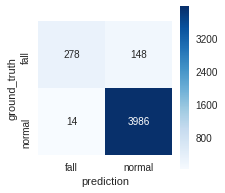

In [7]:
conf_mat, _ = get_confusion_matrix(M, saver, src.train, restore_names, iteration=Iter)
conf_mat = np.array(conf_mat)
index = ['fall','normal']
columns = ['fall','normal']
df = pd.DataFrame(conf_mat, index = index, columns = columns)
fig, ax = plt.subplots(1, figsize=(3,3))
sns.heatmap(df, annot=True, square=True, cmap='Blues', fmt="d")
plt.xlabel('prediction')
plt.ylabel('ground_truth')
fig.show()

In [8]:
precision = (float(conf_mat[0,0]) / (conf_mat[0,0] + conf_mat[1,0]))
recall = (float(conf_mat[0,0]) / (conf_mat[0,0] + conf_mat[0,1]))
print("Precision =", precision, "Recall =", recall)

('Precision =', 0.952054794520548, 'Recall =', 0.6525821596244131)


### Source Test

['model=dann_embed_src=wifistanford_trg=wifimexico_design=conv_1d_trim=4_dw=1e-02_sbw=1e+00_cw=1e-02_tbw=1e-02_dirt=00000_init=0_pivot=90000_up=0_uval=0e+00_dn=0_dcval=0e+00_dwdn=0_phase=0_run=0001']
INFO:tensorflow:Restoring parameters from checkpoints/model=dann_embed_src=wifistanford_trg=wifimexico_design=conv_1d_trim=4_dw=1e-02_sbw=1e+00_cw=1e-02_tbw=1e-02_dirt=00000_init=0_pivot=90000_up=0_uval=0e+00_dn=0_dcval=0e+00_dwdn=0_phase=0_run=0001/model-80000
INFO:tensorflow:Restoring parameters from checkpoints/model=dann_embed_src=wifistanford_trg=wifimexico_design=conv_1d_trim=4_dw=1e-02_sbw=1e+00_cw=1e-02_tbw=1e-02_dirt=00000_init=0_pivot=90000_up=0_uval=0e+00_dn=0_dcval=0e+00_dwdn=0_phase=0_run=0001/model-80000
INFO:tensorflow:Restoring parameters from checkpoints/model=dann_embed_src=wifistanford_trg=wifimexico_design=conv_1d_trim=4_dw=1e-02_sbw=1e+00_cw=1e-02_tbw=1e-02_dirt=00000_init=0_pivot=90000_up=0_uval=0e+00_dn=0_dcval=0e+00_dwdn=0_phase=0_run=0001/model-80000
INFO:tensorflo

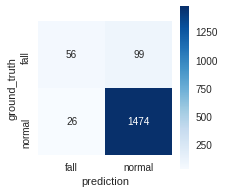

In [9]:
conf_mat, _ = get_confusion_matrix(M, saver, src.test, restore_names, iteration=Iter)
conf_mat = np.array(conf_mat)
index = ['fall','normal']
columns = ['fall','normal']
df = pd.DataFrame(conf_mat, index = index, columns = columns)
fig, ax = plt.subplots(1, figsize=(3,3))
sns.heatmap(df, annot=True, square=True, cmap='Blues', fmt="d")
plt.xlabel('prediction')
plt.ylabel('ground_truth')
fig.show()

In [10]:
precision = (float(conf_mat[0,0]) / (conf_mat[0,0] + conf_mat[1,0]))
recall = (float(conf_mat[0,0]) / (conf_mat[0,0] + conf_mat[0,1]))
print("Precision =", precision, "Recall =", recall)

('Precision =', 0.6829268292682927, 'Recall =', 0.36129032258064514)


### Target Train

['model=dann_embed_src=wifistanford_trg=wifimexico_design=conv_1d_trim=4_dw=1e-02_sbw=1e+00_cw=1e-02_tbw=1e-02_dirt=00000_init=0_pivot=90000_up=0_uval=0e+00_dn=0_dcval=0e+00_dwdn=0_phase=0_run=0001']
INFO:tensorflow:Restoring parameters from checkpoints/model=dann_embed_src=wifistanford_trg=wifimexico_design=conv_1d_trim=4_dw=1e-02_sbw=1e+00_cw=1e-02_tbw=1e-02_dirt=00000_init=0_pivot=90000_up=0_uval=0e+00_dn=0_dcval=0e+00_dwdn=0_phase=0_run=0001/model-80000
INFO:tensorflow:Restoring parameters from checkpoints/model=dann_embed_src=wifistanford_trg=wifimexico_design=conv_1d_trim=4_dw=1e-02_sbw=1e+00_cw=1e-02_tbw=1e-02_dirt=00000_init=0_pivot=90000_up=0_uval=0e+00_dn=0_dcval=0e+00_dwdn=0_phase=0_run=0001/model-80000
INFO:tensorflow:Restoring parameters from checkpoints/model=dann_embed_src=wifistanford_trg=wifimexico_design=conv_1d_trim=4_dw=1e-02_sbw=1e+00_cw=1e-02_tbw=1e-02_dirt=00000_init=0_pivot=90000_up=0_uval=0e+00_dn=0_dcval=0e+00_dwdn=0_phase=0_run=0001/model-80000


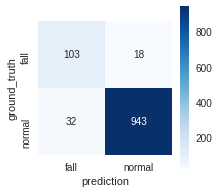

In [11]:
conf_mat, prediction_vada = get_confusion_matrix(M, saver, trg.train, restore_names, iteration=Iter)
conf_mat = np.array(conf_mat)
index = ['fall','normal']
columns = ['fall','normal']
df = pd.DataFrame(conf_mat, index = index, columns = columns)
fig, ax = plt.subplots(1, figsize=(3,3))
sns.heatmap(df, annot=True, square=True, cmap='Blues', fmt="d")
plt.xlabel('prediction')
plt.ylabel('ground_truth')
fig.show()

In [12]:
precision = (float(conf_mat[0,0]) / (conf_mat[0,0] + conf_mat[1,0]))
recall = (float(conf_mat[0,0]) / (conf_mat[0,0] + conf_mat[0,1]))
print("Precision =", precision, "Recall =", recall)

('Precision =', 0.762962962962963, 'Recall =', 0.8512396694214877)


### Target Test

['model=dann_embed_src=wifistanford_trg=wifimexico_design=conv_1d_trim=4_dw=1e-02_sbw=1e+00_cw=1e-02_tbw=1e-02_dirt=00000_init=0_pivot=90000_up=0_uval=0e+00_dn=0_dcval=0e+00_dwdn=0_phase=0_run=0001']
INFO:tensorflow:Restoring parameters from checkpoints/model=dann_embed_src=wifistanford_trg=wifimexico_design=conv_1d_trim=4_dw=1e-02_sbw=1e+00_cw=1e-02_tbw=1e-02_dirt=00000_init=0_pivot=90000_up=0_uval=0e+00_dn=0_dcval=0e+00_dwdn=0_phase=0_run=0001/model-80000


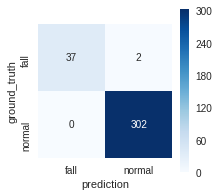

In [13]:
conf_mat, prediction_vada = get_confusion_matrix(M, saver, trg.test, restore_names, iteration=Iter)
conf_mat = np.array(conf_mat)
index = ['fall','normal']
columns = ['fall','normal']
df = pd.DataFrame(conf_mat, index = index, columns = columns)
fig, ax = plt.subplots(1, figsize=(3,3))
sns.heatmap(df, annot=True, square=True, cmap='Blues', fmt="d")
plt.xlabel('prediction')
plt.ylabel('ground_truth')
fig.show()

In [14]:
precision = (float(conf_mat[0,0]) / (conf_mat[0,0] + conf_mat[1,0]))
recall = (float(conf_mat[0,0]) / (conf_mat[0,0] + conf_mat[0,1]))
print("Precision =", precision, "Recall =", recall)

('Precision =', 1.0, 'Recall =', 0.9487179487179487)


In [15]:
acc = get_accuracy(M, saver, src, restore_names, iteration=Iter)
acc = get_accuracy(M, saver, trg, restore_names, iteration=Iter)

INFO:tensorflow:Restoring parameters from checkpoints/model=dann_embed_src=wifistanford_trg=wifimexico_design=conv_1d_trim=4_dw=1e-02_sbw=1e+00_cw=1e-02_tbw=1e-02_dirt=00000_init=0_pivot=90000_up=0_uval=0e+00_dn=0_dcval=0e+00_dwdn=0_phase=0_run=0001/model-80000
[0.96099997758865352, 0.92447130233499586]
INFO:tensorflow:Restoring parameters from checkpoints/model=dann_embed_src=wifistanford_trg=wifimexico_design=conv_1d_trim=4_dw=1e-02_sbw=1e+00_cw=1e-02_tbw=1e-02_dirt=00000_init=0_pivot=90000_up=0_uval=0e+00_dn=0_dcval=0e+00_dwdn=0_phase=0_run=0001/model-80000
[0.95299998521804818, 0.99413486799536566]
